In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import tarfile
import community
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx


In [ ]:
tar_file_path = 'data/period_data.tar'
combined_df = pd.DataFrame()

# Open the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Iterate through each member in the tar file
    for member in tar.getmembers():
        # Check if the file is a .parquet file
        if member.isfile() and member.name.endswith('.parquet'):
            # Extract the file
            extracted_file = tar.extractfile(member)
            if extracted_file:
                # Load the parquet file into a DataFrame
                daily_df = pd.read_parquet(extracted_file)
                # Reset the index and keep it as a column
                daily_df.reset_index(inplace=True)
                # Append to the combined DataFrame
                combined_df = pd.concat([combined_df, daily_df], ignore_index=True)

combined_df


,xltime,bid_price,bid_volume,ask_price,ask_volume,price,stock
0,2012-03-01 09:30:00-05:00,40.934394,178,41.132879,525,41.082622,CORN
1,2012-03-01 09:31:00-05:00,40.972564,72,41.120000,150,41.072183,CORN
2,2012-03-01 09:32:00-05:00,40.995385,25,41.117692,157,41.100892,CORN
3,2012-03-01 09:33:00-05:00,41.008200,100,41.107200,362,41.085771,CORN
4,2012-03-01 09:35:00-05:00,40.974000,25,41.108000,175,41.091250,CORN
...,...,...,...,...,...,...,...
4033941,2012-12-31 15:55:00-05:00,47.417671,55952,47.428298,120881,47.424936,XLY
4033942,2012-12-31 15:56:00-05:00,47.386378,161080,47.396953,227951,47.392575,XLY
4033943,2012-12-31 15:57:00-05:00,47.352095,55767,47.363543,131497,47.360134,XLY
4033944,2012-12-31 15:58:00-05:00,47.370508,67879,47.381836,147840,47.378272,XLY


In [3]:
filtered_df = combined_df.copy()
filtered_df = filtered_df.pivot_table(index='xltime', columns='stock', values='price', aggfunc='mean')
filtered_df.index = pd.to_datetime(filtered_df.index)
filtered_df = filtered_df[filtered_df.index.time < datetime.strptime('15:30', '%H:%M').time()]
# Calculate log-returns for each stock
log_returns = filtered_df.copy()
log_returns.iloc[:, :] = log_returns.apply(lambda col: np.log(col).diff())

log_returns['Date'] = log_returns.index.date
daily_data = log_returns.groupby('Date').apply(lambda x: x.drop(columns='Date').values.flatten())
daily_data_df = pd.DataFrame(daily_data.tolist(), index=daily_data.index)
daily_data_df = daily_data_df.fillna(0)
daily_data_df


,0,1,2,3,4,5,6,7,8,9,...,19790,19791,19792,19793,19794,19795,19796,19797,19798,19799
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000216,0.000230,-0.000077,0.000259,0.000403,-0.000106,-0.000171,0.000162,0.000332
2012-03-02,0.000000,-0.000266,-0.009865,0.000000,0.000000,-0.006257,0.000013,-0.006253,-0.000847,-0.014680,...,0.000000,0.000043,-0.000152,-0.000196,0.000007,0.000090,0.000405,0.000125,-0.000085,-0.000006
2012-03-05,0.004865,0.000000,-0.003587,0.000000,0.000000,-0.002526,-0.002716,-0.004187,-0.004320,-0.008899,...,0.000000,0.000260,0.000178,0.000095,0.000106,0.000177,-0.000084,0.000090,-0.000006,0.000115
2012-03-06,0.000000,-0.026978,-0.017237,0.000000,0.000000,0.000000,-0.012112,-0.029777,-0.019037,-0.048504,...,0.000000,0.000401,0.000308,-0.000044,0.000106,0.000161,-0.000047,0.000482,0.000181,0.000048
2012-03-07,0.000000,0.000000,-0.000155,0.000000,0.000000,0.000000,0.003093,0.000577,0.000862,0.007810,...,0.000000,0.000164,0.000112,-0.000026,0.000251,0.000318,0.000007,0.000099,-0.000042,0.000257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,0.000000,-0.085152,-0.004869,0.000000,0.000000,-0.015294,-0.001794,-0.000975,0.000394,-0.001027,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000088,0.000113,0.000533,-0.000044,0.000342,0.000137,-0.000006,0.000288,0.000265
2012-12-27,-0.002068,0.001568,-0.001167,0.007541,-0.000701,0.010516,-0.001232,0.005859,-0.001977,0.010040,...,0.000000,0.000154,-0.000213,-0.000771,-0.000319,-0.000248,-0.000055,-0.000168,-0.000182,-0.000208


In [4]:
correlation_matrix = daily_data_df.T.corr()
correlation_matrix

Date,2012-03-01,2012-03-02,2012-03-05,2012-03-06,2012-03-07,2012-03-08,2012-03-09,2012-03-12,2012-03-13,2012-03-14,...,2012-12-17,2012-12-18,2012-12-19,2012-12-20,2012-12-21,2012-12-24,2012-12-26,2012-12-27,2012-12-28,2012-12-31
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,1.000000,0.006940,0.010835,0.003785,0.011676,0.004093,-0.008531,0.002743,-0.002048,-0.003448,...,0.029353,0.011966,0.001564,-0.020098,0.012242,0.001777,0.002609,-0.006930,-0.002610,0.002780
2012-03-02,0.006940,1.000000,-0.010074,0.194877,-0.033380,-0.073381,0.182872,0.106537,-0.000951,0.070119,...,0.017244,-0.007247,-0.019562,0.065521,0.098460,0.002997,-0.010411,-0.022362,0.048723,-0.002243
2012-03-05,0.010835,-0.010074,1.000000,0.285238,0.006386,-0.129774,0.113223,0.275948,-0.003532,0.211141,...,0.024417,0.002340,0.033015,0.002810,0.043294,0.003930,-0.003769,0.025665,-0.011402,0.043138
2012-03-06,0.003785,0.194877,0.285238,1.000000,-0.230937,-0.338342,0.314313,0.231177,-0.034141,0.188836,...,0.068502,0.071663,-0.121964,0.292712,0.348711,0.012909,-0.015123,-0.072196,0.217463,0.028019
2012-03-07,0.011676,-0.033380,0.006386,-0.230937,1.000000,0.124830,-0.048025,0.002817,0.025327,0.028739,...,0.037795,-0.064648,0.151877,-0.068302,-0.097594,0.007264,-0.011205,0.061815,-0.100533,0.070276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,0.001777,0.002997,0.003930,0.012909,0.007264,-0.004278,0.005398,0.011002,-0.002065,0.014471,...,0.007098,-0.008155,0.013229,0.008534,0.003509,1.000000,-0.000488,-0.000707,-0.003003,0.009068
2012-12-26,0.002609,-0.010411,-0.003769,-0.015123,-0.011205,0.001433,-0.003642,0.000278,0.009549,0.021131,...,0.006495,-0.022537,-0.015027,0.000196,-0.005858,-0.000488,1.000000,0.004344,0.011621,0.015022
2012-12-27,-0.006930,-0.022362,0.025665,-0.072196,0.061815,0.055109,-0.037699,0.039350,0.035336,0.083858,...,-0.061187,-0.055238,0.116383,0.042988,-0.056845,-0.000707,0.004344,1.000000,-0.086176,0.070255


In [5]:
# process data for louvain clustering
def get_sortest_eig(C):
    '''
    input 
        C: correlation matrix
        
    output: 
        l: eigenvalues
        v: eigenvectors 
    '''
    
    l,v = np.linalg.eigh(C)
    ordn = np.argsort(l)
    l,v = l[ordn],v[:,ordn]
    return l,v

l, v = get_sortest_eig(correlation_matrix)

lambda_limit = 1e-1
len(l[l<lambda_limit]) 
selected_indices = [i for i, l in enumerate(l) if l <= lambda_limit]

C_r = np.zeros_like(correlation_matrix)

for i in selected_indices:
    v_i = v[:, i]  # Get the i-th eigenvector
    outer_product = np.outer(v_i, v_i)  # Compute outer product
    C_r += l[i] * outer_product  # Add scaled matrix to the sum

C_m = l[-1] * np.outer(v[-1, :],v[-1, :])
C_0 = C_r + C_m
C = abs(correlation_matrix - C_0)
G = nx.from_pandas_adjacency(C)

# Apply Louvain clustering
partition = community.community_louvain.best_partition(G, weight='weight')

# Convert results to a DataFrame
clusters = pd.DataFrame({'Day': list(partition.keys()), 'Cluster': list(partition.values())})
len(clusters.groupby('Cluster'))


7

C:\Users\phlev\AppData\Local\Temp\ipykernel_208364\1841700985.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


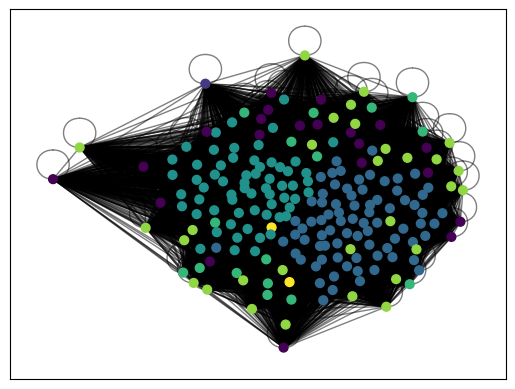

In [6]:
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()